## A 3-step model with Thermodynamic (saturated, reversible) kinetics


$$\mbox{S}_\rm{sugar} \overset{\varepsilon_t}{\rightleftharpoons} \mbox{S}_1 \overset{\varepsilon_m}{\rightleftharpoons} S_2 \overset{\varepsilon_r}{\rightleftharpoons} S_3$$

The rate laws are (Michaelis-Menten):
- Transporters:  $v_t = \varepsilon_t ~ k^\mathrm{cat}_t ~ \left(1 - \frac{s_{1}}{s_\rm{sugar}~K^{\mathrm{eq}}_t}\right)$
- Metabolism:    $v_m = \varepsilon_m ~ k^\mathrm{cat}_m ~ \left(1 - \frac{s_{2}}{s_1~K^{\mathrm{eq}}_m}\right)$
- Ribosomes:     $v_r = \varepsilon_r ~ k^\mathrm{cat}_r ~ \left(1 - \frac{s_{3}}{s_2~K^{\mathrm{eq}}_r}\right)$



We assume that $s_\rm{sugar}$ is fixed and that the system is at steady-state ($v_t = v_m = v_r = \mu$). The enzymes are bound by the following constraint:
- $\varepsilon_t + \varepsilon_m + \varepsilon_r \leq \varepsilon^\mathrm{tot}$

Then, the maximal flux (assuming the total enzyme $\varepsilon^\mathrm{tot}$ is distributed optimally) is:
$$\mu = \mu^\mathrm{max} \cdot \left(1 - \frac{1}{2} \cdot \left(\frac{K_M} {s_\mathrm{sugar}}\right)^B\right)$$
where
- $$\mu^\mathrm{max} \equiv \frac{\varepsilon^\mathrm{tot}}{1 / k^\mathrm{cat}_t + 1 / k^\mathrm{cat}_m + 1 / k^\mathrm{cat}_r}$$
- $$B \equiv \frac{1 / k^\mathrm{cat}_t + 1 / k^\mathrm{cat}_m + 1 / k^\mathrm{cat}_r}{\left(1 / \sqrt{k^\mathrm{cat}_t} + 1 / \sqrt{k^\mathrm{cat}_m} + 1 / \sqrt{k^\mathrm{cat}_r}\right)^2}$$
- $$K_M = \frac{s_3 \cdot \sqrt[B]{2}}{K^{\mathrm{eq}}}$$


<img src="../figures/growing_cell_model.svg" width="800">

In [1]:
import numpy as np
import sympy
import seaborn as sns
from scipy.optimize import minimize, LinearConstraint, Bounds
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["text.usetex"] = True
sympy.init_printing(use_latex=True, scale=2.0, forecolor="black", latex_mode="equation")

In [2]:
# define variables and parameters:
E_tot = sympy.Symbol(r"\varepsilon_{tot}")
s_sugar = sympy.symbols(r"s_{sugar}")
s_3 = sympy.symbols(r"s_3")
kcat = sympy.symbols(r"k^{cat}_t k^{cat}_m k^{cat}_r")
Keq = sympy.symbols(r"K_{eq;t} K_{eq;m} K_{eq;r}")
Keq_tot = sympy.symbols(r"K^{eq}")
J_opt_symbol = sympy.Symbol(r"J^*")
K_half_symbol = sympy.Symbol(r"K_{1/2}")

norm_one = sum(1/k for k in kcat)
norm_half = sum(1/sympy.sqrt(k) for k in kcat)**2

mu_max = E_tot/norm_one
B = norm_one / norm_half
J_opt = mu_max * (1 - (s_3 / s_sugar / Keq_tot)**B)

K_half = (s_3 / Keq_tot) * 2**(1/B)

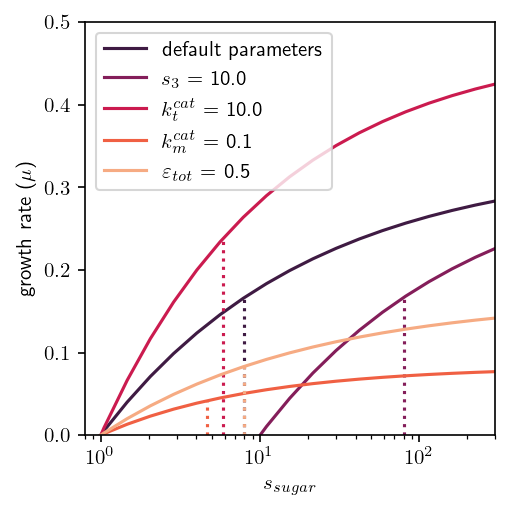

In [3]:
# single-panel version of the sensitivity of J to the different parameters

s_sugar_range = np.logspace(-1, 2.5, 25)
colors = sns.color_palette("rocket", 5)
default_params = {
    Keq_tot: 1,
    kcat[0]: 1,
    kcat[1]: 1,  
    kcat[2]: 1,
    s_3: 1,
    E_tot: 1,
}

def plot_monod_curve(ax, color, key=None, value=None, label=""):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        label = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        label = "default parameters"

    _f = sympy.lambdify(s_sugar, J_opt.subs(p))
    ax.plot(s_sugar_range, _f(s_sugar_range), label=label, color=color)
    K = K_half.subs(p)
    mu_half = mu_max.subs(p) / 2.0
    ax.plot([K, K], [0, mu_half], ":", color=color, linewidth=1.5)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=150)

plot_monod_curve(ax, color=colors[0])
plot_monod_curve(ax, color=colors[1], key=s_3, value=10.0)
plot_monod_curve(ax, color=colors[2], key=kcat[0], value=10.0)
plot_monod_curve(ax, color=colors[3], key=kcat[1], value=0.1)
plot_monod_curve(ax, color=colors[4], key=E_tot, value=0.5)
ax.set_xscale("log")
ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
ax.set_ylabel(f"growth rate ($\mu$)")
ax.set_xlim(8e-1, 300)
ax.set_ylim(0, 0.5)
ax.legend()

fig.tight_layout()
fig.savefig("../figures/thermodynamic_mu_vs_s0_singlepanel.pdf")

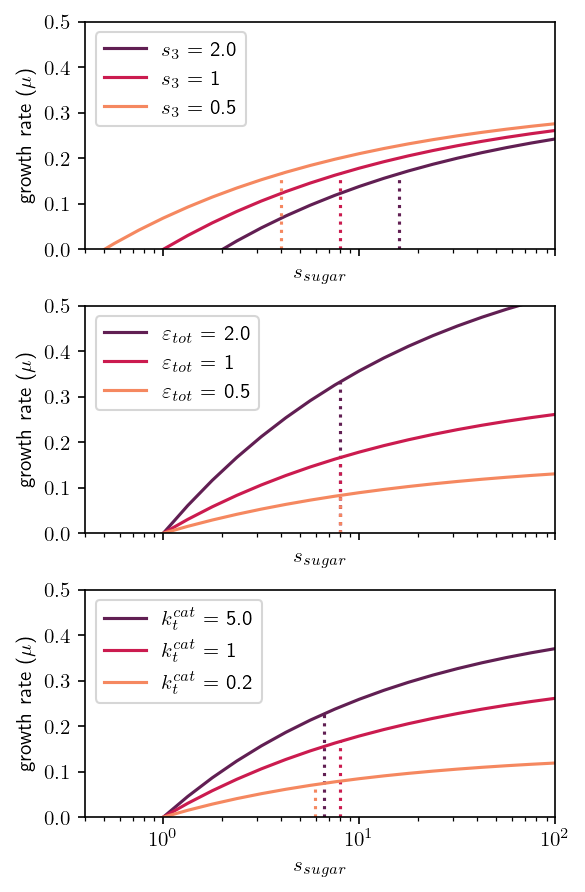

In [4]:
s_sugar_range = np.logspace(-1, 2, 25)
colors = sns.color_palette("rocket", 3)
default_params = {
    Keq_tot: 1,
    kcat[0]: 1,
    kcat[1]: 1,  
    kcat[2]: 1,
    s_3: 1,
    E_tot: 1,
}
def plot_monod_curve(ax, color=colors[1], key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        label = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        label = "default parameters"

    _f = sympy.lambdify(s_sugar, J_opt.subs(p))
    ax.plot(s_sugar_range, _f(s_sugar_range), label=label, color=color)
    K = K_half.subs(p)
    mu_half = mu_max.subs(p) / 2.0
    ax.plot([K, K], [0, mu_half], ":", color=color, linewidth=1.5)

def plot_three_monod_curves(ax, key, fold_change: float=10.0):
    plot_monod_curve(ax, color=colors[0], key=key, value=default_params[key]*fold_change)
    plot_monod_curve(ax, color=colors[1], key=key, value=default_params[key])
    plot_monod_curve(ax, color=colors[2], key=key, value=default_params[key]/fold_change)
    ax.set_xscale("log")
    ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
    ax.set_ylabel(f"growth rate ($\mu$)")
    ax.set_xlim(4e-1, 1e2)
    ax.set_ylim(0, 0.5)
    ax.legend()

    
fig, axs = plt.subplots(3, 1, figsize=(4, 6), dpi=150, sharex=True, sharey=True)

axs = list(axs.flat)
plot_three_monod_curves(axs[0], key=s_3, fold_change=2.)
plot_three_monod_curves(axs[1], key=E_tot, fold_change=2.)
plot_three_monod_curves(axs[2], key=kcat[0], fold_change=5.)

fig.tight_layout()
fig.savefig("../figures/thermodynamic_mu_vs_s0.pdf")

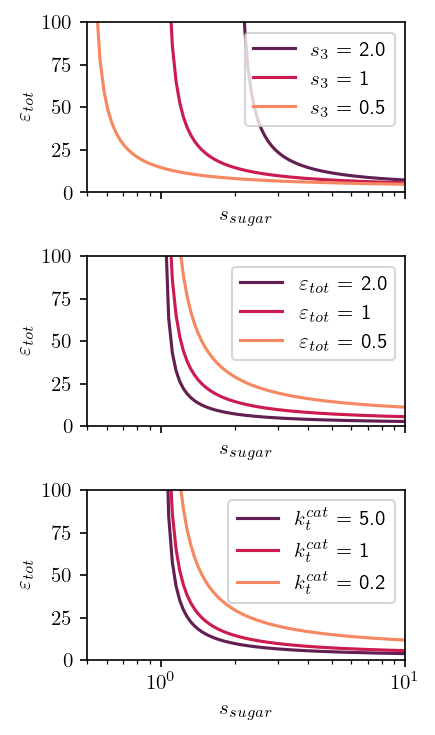

In [5]:
# now plot the enzyme demand per flux:
J_steady_state = sympy.Symbol("J")
colors = sns.color_palette("rocket", 3)
default_params = {
    Keq_tot: 1,
    kcat[0]: 1,
    kcat[1]: 1,  
    kcat[2]: 1,
    s_3: 1,
    E_tot: 1,
    J_steady_state: 1,
}
enzyme_demand = J_steady_state / J_opt

log_s_sugar_eq = sympy.log(s_3 / Keq_tot)


def plot_enzye_demand(ax, color="#e17701", key=None, value=None):
    if key is not None:
        p = default_params.copy()
        p[key] = value
        label = f"${sympy.latex(key)}$ = {value}"
    else:
        p = default_params
        label = "default parameters"
    _f = sympy.lambdify(s_sugar, enzyme_demand.subs(p))
    s_init = float(log_s_sugar_eq.subs(p))/np.log(10) + 1e-3
    s_sugar_range = np.logspace(s_init, 3, 200)
    ax.plot(s_sugar_range, _f(s_sugar_range), label=label, color=color)

def plot_three_demand_curves(ax, key, fold_change: float=10.0):
    plot_enzye_demand(ax, color=colors[0], key=key, value=default_params[key]*fold_change)
    plot_enzye_demand(ax, color=colors[1], key=key, value=default_params[key])
    plot_enzye_demand(ax, color=colors[2], key=key, value=default_params[key]/fold_change)
    ax.set_xscale("log")
    ax.set_xlabel(f"${sympy.latex(s_sugar)}$")
    ax.set_ylabel(r"$\varepsilon_{tot}$")
    ax.set_xlim(5e-1, 1e1)
    ax.set_ylim(0, 100)
    ax.legend()

    
fig, axs = plt.subplots(3, 1, figsize=(3, 5), dpi=150, sharex=True, sharey=True)

axs = list(axs.flat)

plot_three_demand_curves(axs[0], key=s_3, fold_change=2.)
plot_three_demand_curves(axs[1], key=E_tot, fold_change=2.)
plot_three_demand_curves(axs[2], key=kcat[0], fold_change=5.)

fig.tight_layout()
fig.savefig("../figures/thermodynamic_Etot_vs_s0.pdf")

## Calculate individual enzyme demands

In [6]:
asinh = lambda x: np.log(x + (x**2 + 1.)**(0.5))
Gj = lambda psi, k: asinh( (psi/k)**0.5 )
G = lambda psi, ks:  2. * sum([ Gj(psi, k) for k in ks ])
Ej = lambda psi, k: 1. / k * (1. + (1. + k/psi)**0.5)/2.
fluxJ = lambda x, ks: 1 / sum([ Ej(x, k) for k in ks ])

norm = lambda y, ks: sum([k**y for k in ks])**(1/y)
n_one = lambda ks: 1/norm(-1, ks)
n_half = lambda ks: 1/norm(-0.5, ks)

In [7]:
E_tot = sympy.Symbol(r"\varepsilon_{tot}")
s_3 = sympy.symbols(r"s_3")
kcat = sympy.symbols(r"k^{cat}_t k^{cat}_m k^{cat}_r")
Keq_tot = sympy.symbols(r"K^{eq}")
Psi = sympy.Symbol("Ψ")

theta = 2*sum([ sympy.log((Psi/k)**0.5 + (1 + Psi/k)**0.5) for k in kcat])
s_sugar = s_3 * sympy.exp(theta) / Keq_tot

relative_demand = [1 / k * (1 + (1 + k/Psi)**0.5)/2 for k in kcat]
J = E_tot / sum(relative_demand)
enzyme_demands = [Ei * J for Ei in relative_demand]

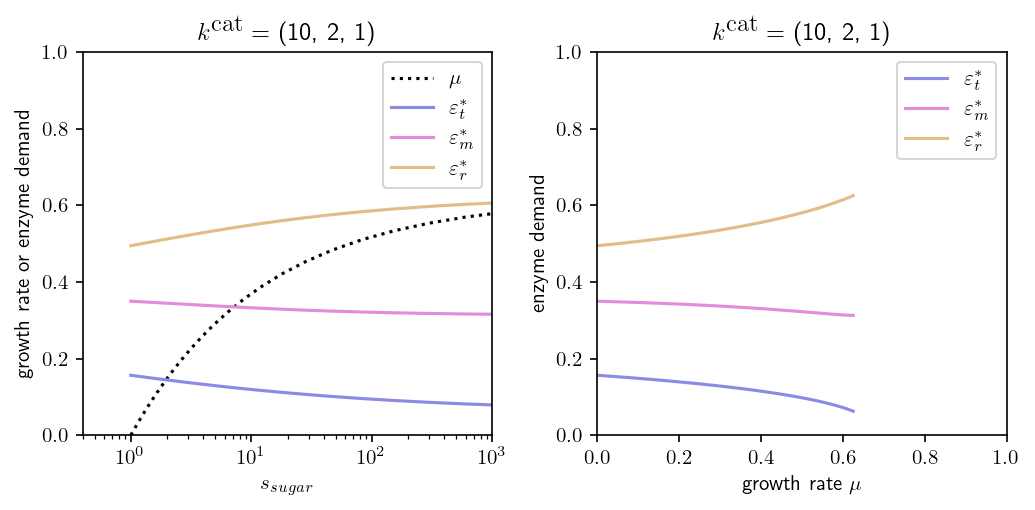

In [8]:
Psi_range = np.logspace(-10, 4, 100)
colors = ["#8b8be4", "#e48bdc", "#e4bc8b"]
default_params = {
    E_tot: 1,
    s_3: 1,
    kcat[0]: 10,
    kcat[1]: 2,  
    kcat[2]: 1,
    Keq_tot: 1,
}
s_eq = s_3/Keq_tot

fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), dpi=150)

ax = axs[0]
_fx = sympy.lambdify(Psi, s_sugar.subs(default_params))
_fJ = sympy.lambdify(Psi, J.subs(default_params))
ax.plot(_fx(Psi_range), _fJ(Psi_range), ':', label=f"$\mu$", color="k")
for demand, letter, c in zip(enzyme_demands, ["t", "m", "r"], colors):
    _fy = sympy.lambdify(Psi, demand.subs(default_params))
    ax.plot(_fx(Psi_range), _fy(Psi_range), label=f"$\\varepsilon^*_{letter}$", color=c)

ax.set_xscale("log")
ax.set_xlabel(r"$s_{sugar}$")
ax.set_ylabel(r"growth rate or enzyme demand")
ax.set_xlim(4e-1, 1e3)
ax.set_ylim(0, 1)
ax.legend()
ax.set_title(label=r"$k^\textrm{cat} =$ (" + ', '.join([str(default_params[k]) for k in kcat]) + ")")


ax = axs[1]
for demand, letter, c in zip(enzyme_demands, ["t", "m", "r"], colors):
    _fy = sympy.lambdify(Psi, demand.subs(default_params))
    ax.plot(_fJ(Psi_range), _fy(Psi_range), label=f"$\\varepsilon^*_{letter}$", color=c)

ax.set_xlabel(r"growth rate $\mu$")
ax.set_ylabel(r"enzyme demand")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.set_title(label=r"$k^\textrm{cat} =$ (" + ', '.join([str(default_params[k]) for k in kcat]) + ")")

fig.tight_layout()
fig.savefig("../figures/thermodynamic_demands.pdf")

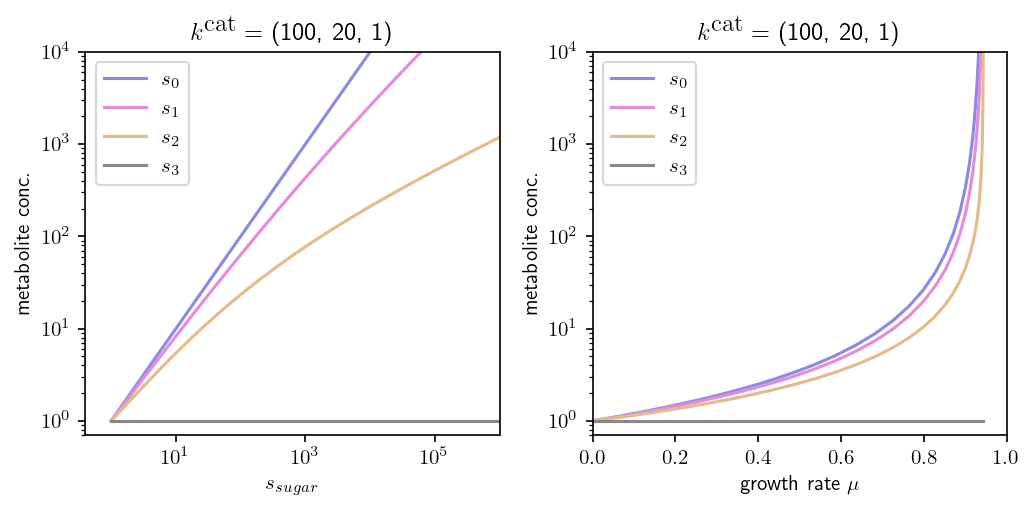

In [9]:
# plot the 4 metabolite concentrations as a function of s_sugar

# θ_i = ln(s_i-1 * Keq_i / s_i)
# θ_i = 2 ln( sqrt(Ψ α_i) + sqrt(Ψ α_i + 1) )

s_2 = s_3 / Keq[2] / ( (Psi/kcat[2])**0.5 + (Psi/kcat[2]+1)**0.5 )**(-2)
s_1 = s_2 / Keq[1] / ( (Psi/kcat[1])**0.5 + (Psi/kcat[1]+1)**0.5 )**(-2)
metabolite_conc = [
    s_sugar,
    sympy.simplify(s_1),
    sympy.simplify(s_2),
    s_3
]

Psi_range = np.logspace(-10, 4, 100)
colors = ["#8b8be4", "#e48bdc", "#e4bc8b", "#888888"]
default_params = {
    E_tot: 1,
    s_3: 1,
    kcat[0]: 100,
    kcat[1]: 20,  
    kcat[2]: 1,
    Keq[0]: 1,
    Keq[1]: 1,
    Keq[2]: 1,
    Keq_tot: 1,
}
s_eq = s_3/Keq_tot

fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), dpi=150)

ax = axs[0]
_fx = sympy.lambdify(Psi, s_sugar.subs(default_params))
for i, conc in enumerate(metabolite_conc):
    _fy = sympy.lambdify(Psi, conc.subs(default_params))
    ax.plot(_fx(Psi_range), [_fy(p) for p in Psi_range], label=f"$s_{i}$", color=colors[i])

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$s_{sugar}$")
ax.set_ylabel(r"metabolite conc.")
ax.set_xlim(4e-1, 1e6)
ax.set_ylim(7e-1, 1e4)
ax.legend()
ax.set_title(label=r"$k^\textrm{cat} =$ (" + ', '.join([str(default_params[k]) for k in kcat]) + ")")


ax = axs[1]
_fJ = sympy.lambdify(Psi, J.subs(default_params))
for i, conc in enumerate(metabolite_conc):
    _fy = sympy.lambdify(Psi, conc.subs(default_params))
    ax.plot(_fJ(Psi_range), [_fy(p) for p in Psi_range], label=f"$s_{i}$", color=colors[i])

ax.set_yscale("log")
ax.set_xlabel(r"growth rate $\mu$")
ax.set_ylabel(r"metabolite conc.")
ax.set_xlim(0, 1)
ax.set_ylim(7e-1, 1e4)
ax.legend()
ax.set_title(label=r"$k^\textrm{cat} =$ (" + ', '.join([str(default_params[k]) for k in kcat]) + ")")

fig.tight_layout()
fig.savefig("../figures/thermodynamic_metabolites.pdf")